In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
from functools import partial

from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from RaTag.scripts.analyse_field_scans import * # type: ignore
from scipy.optimize import curve_fit

# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


# Field scan, low range

In [2]:
def extract_voltage_pairs(base_dir, pattern=None):
    """Extract (anode_voltage, gate_voltage) pairs from subdirectory names."""
    voltage_pairs = []
    if pattern is None:
        pattern = 'FieldScan_1GSsec_EL{}_Gate{}'
    subdirs = sorted(os.listdir(base_dir))
    for subdir in subdirs:
        try:
            gate_voltage = int(re.search(r'Gate(\d+)', subdir).group(1))
            anode_voltage = int(re.search(r'Anode(\d+)', subdir).group(1))
            # print(f"Anode voltage : {anode_voltage}, Gate voltage : {gate_voltage}")
            voltage_pairs.append((anode_voltage, gate_voltage))
        except AttributeError:
            continue
    return np.array(voltage_pairs)

In [3]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec'
pattern = 'FieldScan_5GSsec_Anode{}V_Gate{}V'
fitter = GaussianFitter

area_extractor = partial(
    S2AreaExtractor,
    threshold_bs=0.07,
    integ_window=(1e-6, 3.5e-5),
    bs_t_window=(-1.5e-5, -1.0e-5),
    bs_v_window=(-0.005, 0.005)
)

In [16]:
analyzer = FieldScanAnalyzer(
    base_dir,
    n_files=10_000,
    pattern=pattern,
    to_drop=[(4000, 2100)],
    areaExtractor=area_extractor,
    fitter=GaussianFitter,
    hist_cuts=(-5, 120),
    nbins=120,
    EL_gap=0.8,
    drift_gap=1.4
)

In [17]:
s2_areas_cuts, s2_areas = analyzer.analyze();

Integrating 10000 files for EL 1950 V, Gate 50 V
Integrating 10000 files for EL 2000 V, Gate 100 V
Integrating 10000 files for EL 2100 V, Gate 200 V
Integrating 10000 files for EL 2500 V, Gate 600 V
Integrating 10000 files for EL 3000 V, Gate 1100 V
Integrating 10000 files for EL 3500 V, Gate 1600 V


<Axes: title={'center': 'Drift field scan, EL field: 2375.0 kV/cm'}, xlabel='S2 Area (mV*us)', ylabel='Counts'>

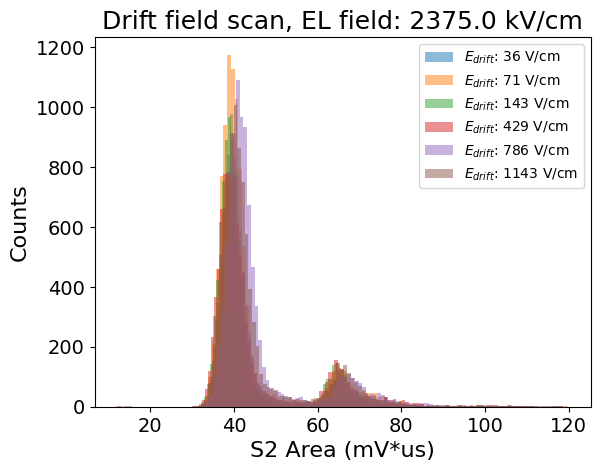

In [18]:
analyzer.plot_histograms()

50 V: amplitude=1074.64, mean=39.52, sigma=2.53)
50 V: amplitude=100.54, mean=65.82, sigma=-3.79)
100 V: amplitude=1405.88, mean=39.37, sigma=2.40)
100 V: amplitude=133.52, mean=66.06, sigma=4.15)
200 V: amplitude=1117.41, mean=38.85, sigma=2.33)
200 V: amplitude=154.92, mean=65.02, sigma=-2.96)
600 V: amplitude=958.55, mean=39.07, sigma=2.76)
600 V: amplitude=153.09, mean=64.92, sigma=-3.20)
1100 V: amplitude=1247.11, mean=41.25, sigma=2.68)
1100 V: amplitude=112.54, mean=67.98, sigma=4.54)
1600 V: amplitude=1141.20, mean=40.23, sigma=2.83)
1600 V: amplitude=89.64, mean=131.04, sigma=-4.76)


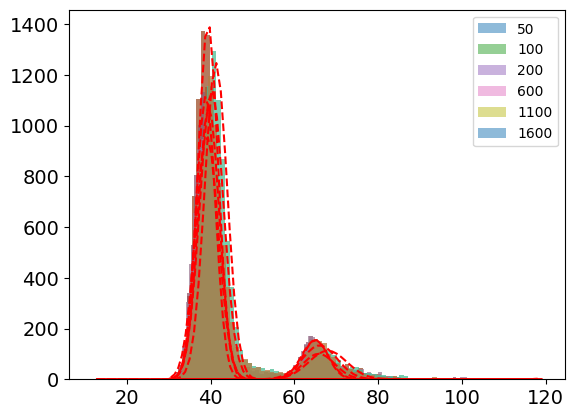

In [20]:
analyzer.fit_histograms_2peaks(sep_A=58);

[(30.0, 100.0)]

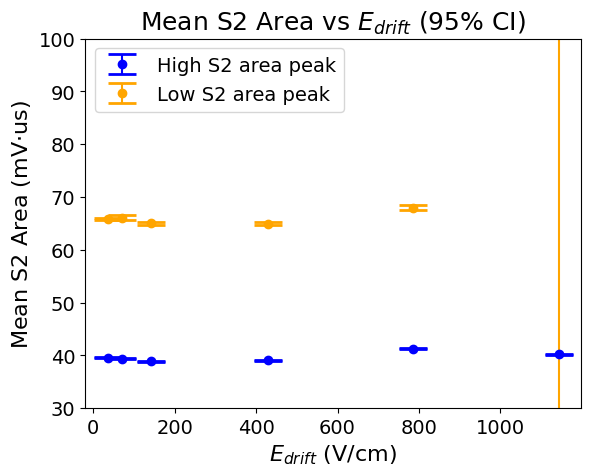

In [26]:
analyzer.plot_s2_vs_field()
plt.gca().set(ylim=(30, 100))

In [8]:
fields_over_lim = check_fields(analyzer.voltage_pairs, analyzer.E_el, analyzer.E_drift )
E_el0, E_drift = fields_over_lim[0]


 [2100  700]
 [2150  750]
 [2200  800]
 [2600 1200]
 [3100 1700]
 [3600 2200]
 [4100 2700]] V


In [18]:
print([round(e, 1) for e in analyzer.E_drift])

[35.7, 42.9, 46.4, 50.0, 53.6, 71.4, 107.1, 178.6, 250.0, 321.4, 392.9, 428.6, 464.3, 500.0, 535.7, 571.4, 857.1, 1214.3, 1571.4, 1928.6]


[Text(0.5, 0, 'Drift Field (V/cm)'),
 Text(0, 0.5, 'S2 Area (PE)'),
 Text(0.5, 1.0, 'S2 Area vs Drift Field at EL=1450 V/cm')]

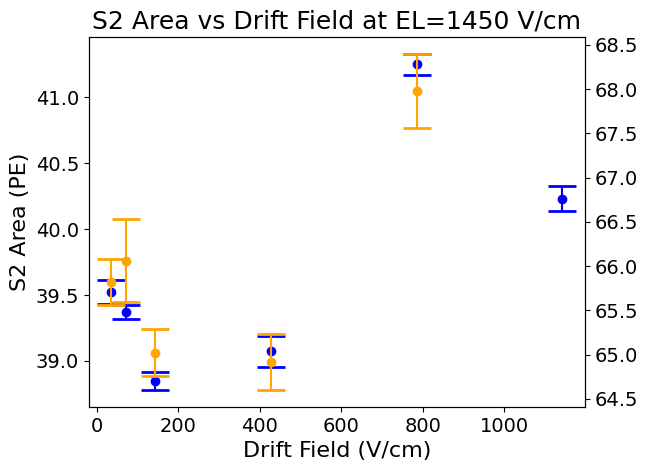

In [28]:
mean_p1, ci95_p1 = zip(*analyzer.fit_results_p1.values())
mean_p2, ci95_p2 = zip(*analyzer.fit_results_p2.values())
E_d = [analyzer.E_dr_dict[v] for v in analyzer.fit_results_p1.keys()]
ax = plt.gca()
ax2 = ax.twinx()
ax.errorbar(E_d, mean_p1, yerr=ci95_p1, fmt='o', color='blue', capsize=10, capthick=2, label='High S2 area peak')
ax2.errorbar(E_d[:-1], mean_p2[:-1], yerr=ci95_p2[:-1], fmt='o', color='orange', capsize=10, capthick=2, label='Low S2 area peak')
ax.set(xlabel='Drift Field (V/cm)', ylabel='S2 Area (PE)', title='S2 Area vs Drift Field at EL=1450 V/cm')

[Text(0.5, 0, 'Drift Field (V/cm)'),
 Text(0, 0.5, 'S2 Area (PE)'),
 Text(0.5, 1.0, 'S2 Area vs Drift Field at EL=1750 V/cm')]

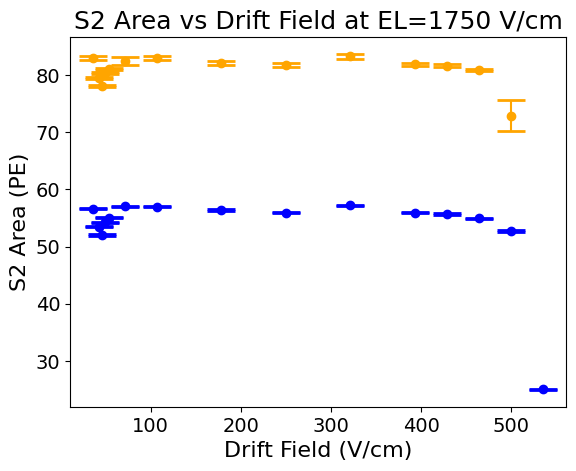

In [ ]:
mean_p1, ci95_p1 = zip(*analyzer.fit_results_p1.values())
mean_p2, ci95_p2 = zip(*analyzer.fit_results_p2.values())
E_d = [analyzer.E_dr_dict[v] for v in analyzer.fit_results_p1.keys()]
ax = plt.gca()
ax.errorbar(E_d, mean_p1, yerr=ci95_p1, fmt='o', color='blue', capsize=10, capthick=2, label='High S2 area peak')
ax.errorbar(E_d[:-1], mean_p2[:-1], yerr=ci95_p2[:-1], fmt='o', color='orange', capsize=10, capthick=2, label='Low S2 area peak')
ax.set(xlabel='Drift Field (V/cm)', ylabel='S2 Area (PE)', title='S2 Area vs Drift Field at EL=1750 V/cm')